In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-books-reviews/books_data.csv
/kaggle/input/amazon-books-reviews/Books_rating.csv
/kaggle/input/dataset/balanced30k.csv
/kaggle/input/books-dataset-goodreadsmay-2024/books.db
/kaggle/input/books-dataset-goodreadsmay-2024/book_reviews.db
/kaggle/input/books-dataset-goodreadsmay-2024/Book_Details.csv


In [2]:
df = pd.read_csv('/kaggle/input/dataset/balanced30k.csv')

In [3]:
df.head()

,Title,review/score,review/text,categories,word_count,label
0,The Good Earth,2.0,The book The Good Earth is about the rise and ...,Juvenile Fiction,262,0
1,Like Water for Chocolate,4.0,"Don't know why this book sticks in my mind, bu...",Fiction,55,2
2,Shadowy Horses,4.0,By far the best of the latest crop of Romantic...,Fiction,247,2
3,"The Hobbitt, or there and back again; illustra...",5.0,"Classic tale, great illustrations. A known qua...",Fiction,23,2
4,Shamanspace,1.0,"For the past year, I had come across Steve Ayl...",Fiction,226,0


In [4]:
import re
def clean_for_transformer(text):
    text = str(text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [5]:
df['cleaned_text'] = df['review/text'].apply(clean_for_transformer)
df.head()

,Title,review/score,review/text,categories,word_count,label,cleaned_text
0,The Good Earth,2.0,The book The Good Earth is about the rise and ...,Juvenile Fiction,262,0,The book The Good Earth is about the rise and ...
1,Like Water for Chocolate,4.0,"Don't know why this book sticks in my mind, bu...",Fiction,55,2,"Don't know why this book sticks in my mind, bu..."
2,Shadowy Horses,4.0,By far the best of the latest crop of Romantic...,Fiction,247,2,By far the best of the latest crop of Romantic...
3,"The Hobbitt, or there and back again; illustra...",5.0,"Classic tale, great illustrations. A known qua...",Fiction,23,2,"Classic tale, great illustrations. A known qua..."
4,Shamanspace,1.0,"For the past year, I had come across Steve Ayl...",Fiction,226,0,"For the past year, I had come across Steve Ayl..."


In [6]:
from sklearn.model_selection import train_test_split
X = df['cleaned_text']
y = df['label']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp
)

In [7]:
from datasets import Dataset
train_df = pd.DataFrame({'text': X_train, 'label': y_train})
val_df   = pd.DataFrame({'text': X_val,   'label': y_val})
test_df  = pd.DataFrame({'text': X_test,  'label': y_test})

train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
val_dataset   = Dataset.from_pandas(val_df,   preserve_index=False)
test_dataset  = Dataset.from_pandas(test_df,  preserve_index=False)

In [8]:
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)

tokenizer = AutoTokenizer.from_pretrained('roberta-base', use_fast=True)

def tokenize(batch):
    return tokenizer( batch['text'],padding='max_length',truncation=True,max_length=256)

train_dataset = train_dataset.map(tokenize, batched=True, remove_columns=['text'])
val_dataset   = val_dataset.map(tokenize,   batched=True, remove_columns=['text'])
test_dataset  = test_dataset.map(tokenize,  batched=True, remove_columns=['text'])

2025-09-07 21:35:56.415667: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757280956.780945      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757280956.888031      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/21000 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [9]:
# Set PyTorch format
cols = ['input_ids', 'attention_mask', 'label']
train_dataset.set_format(type='torch', columns=cols)
val_dataset.set_format(type='torch',   columns=cols)
test_dataset.set_format(type='torch',  columns=cols)

model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        'accuracy':  accuracy_score(labels, preds),
        'precision': precision_score(labels, preds, average='macro', zero_division=0),
        'recall':    recall_score(labels, preds, average='macro', zero_division=0),
        'f1':        f1_score(labels, preds, average='macro', zero_division=0),
    }

In [11]:
#Training arguments
training_args = TrainingArguments(
    output_dir="./roberta_fiction_sentiment/3",
    #evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_strategy="steps",
    logging_steps=10,
    report_to="none",
    #load_best_model_at_end=True,
    metric_for_best_model="f1"
)

In [12]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipykernel_19/2721217396.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [13]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1.106900
20,1.089900
30,0.994600
40,0.891900
50,0.773700
60,0.706700
70,0.714400
80,0.644200
90,0.607300
100,0.650800


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=1971, training_loss=0.48515888303140287, metrics={'train_runtime': 1671.3231, 'train_samples_per_second': 37.695, 'train_steps_per_second': 1.179, 'total_flos': 8288072658432000.0, 'train_loss': 0.48515888303140287, 'epoch': 3.0})

In [ ]:
# Validation set
pred = trainer.predict(val_dataset)
logits = pred.predictions
y_true = pred.label_ids
y_pred = logits.argmax(axis=1)

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [15]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

print(classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive'],zero_division=0))


              precision    recall  f1-score   support

    Negative       0.80      0.83      0.82      2000
     Neutral       0.69      0.66      0.67      2000
    Positive       0.84      0.84      0.84      2000

    accuracy                           0.78      6000
   macro avg       0.77      0.78      0.77      6000
weighted avg       0.77      0.78      0.77      6000



In [16]:
from transformers.trainer_utils import get_last_checkpoint
import os
import json
import matplotlib.pyplot as plt

log_file = "./roberta_fiction_sentiment/3/checkpoint-1971/trainer_state.json"

with open(log_file) as f:
    data = json.load(f)

steps = []
losses = []

for log in data["log_history"]:
    if "loss" in log:
        steps.append(log["step"])
        losses.append(log["loss"])

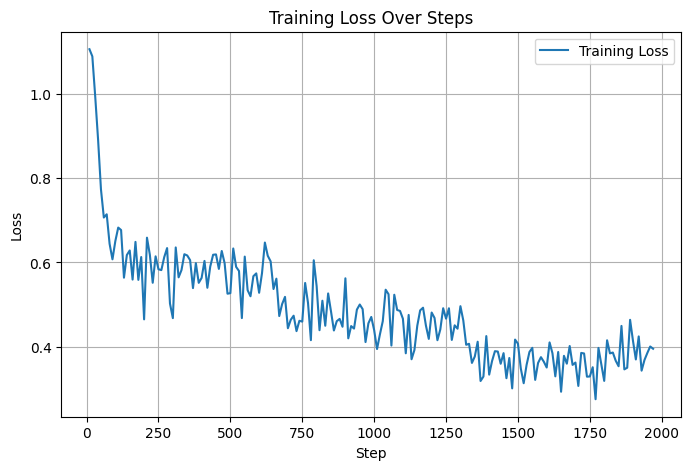

In [17]:
# Plot
plt.figure(figsize=(8, 5))
plt.plot(steps, losses, label="Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Over Steps")
plt.grid(True)
plt.legend()
plt.savefig("roberta_training_loss.png", dpi=300, bbox_inches="tight")
plt.show()

In [18]:
# Evaluate on test set
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
preds = trainer.predict(test_dataset)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)
print(classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive'], zero_division=0))

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


              precision    recall  f1-score   support

    Negative       0.79      0.81      0.80      1000
     Neutral       0.68      0.66      0.67      1000
    Positive       0.84      0.84      0.84      1000

    accuracy                           0.77      3000
   macro avg       0.77      0.77      0.77      3000
weighted avg       0.77      0.77      0.77      3000



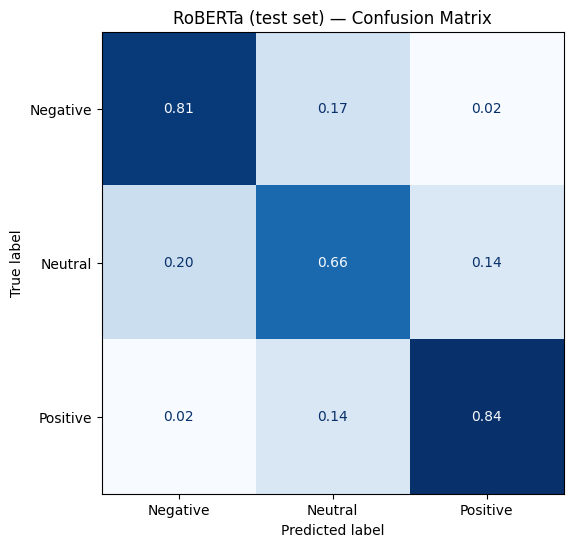

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
plt.title("RoBERTa (test set) — Confusion Matrix")
plt.savefig("roberta_confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()



In [ ]:
# Extract non-fiction book 
import pandas as pd
br = pd.read_csv('/kaggle/input/amazon-books-reviews/Books_rating.csv')
br.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


In [21]:
bd = pd.read_csv('/kaggle/input/amazon-books-reviews/books_data.csv')
bd.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN
4,"Nation Dance: Religion, Identity and Cultural ...",NaN,['Edward Long'],NaN,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,2003-03-01,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,NaN


In [22]:
books = pd.merge(br,bd, on = 'Title')
books.shape

(3000000, 19)

In [23]:
df = books[['Title','review/score','review/text','categories']]
df.head()

,Title,review/score,review/text,categories
0,Its Only Art If Its Well Hung!,4.0,This is only for Julie Strain fans. It's a col...,['Comics & Graphic Novels']
1,Dr. Seuss: American Icon,5.0,I don't care much for Dr. Seuss but after read...,['Biography & Autobiography']
2,Dr. Seuss: American Icon,5.0,"If people become the books they read and if ""t...",['Biography & Autobiography']
3,Dr. Seuss: American Icon,4.0,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",['Biography & Autobiography']
4,Dr. Seuss: American Icon,4.0,Philip Nel - Dr. Seuss: American IconThis is b...,['Biography & Autobiography']


In [24]:
df.drop_duplicates(inplace = True)
df.shape

/tmp/ipykernel_19/3208856916.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace = True)


(2617289, 4)

In [25]:
df.dropna(inplace=True)
df.isna().sum()

/tmp/ipykernel_19/3486782518.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


Title           0
review/score    0
review/text     0
categories      0
dtype: int64

In [26]:
df.shape

(2151435, 4)

In [27]:
df = df[~df['categories'].str.contains('Fiction', case=False, na=False)]
df.shape

(1230886, 4)

In [28]:
df['categories'] = df['categories'].str.extract(r'\'(.*)\'')
df.head()

,Title,review/score,review/text,categories
0,Its Only Art If Its Well Hung!,4.0,This is only for Julie Strain fans. It's a col...,Comics & Graphic Novels
1,Dr. Seuss: American Icon,5.0,I don't care much for Dr. Seuss but after read...,Biography & Autobiography
2,Dr. Seuss: American Icon,5.0,"If people become the books they read and if ""t...",Biography & Autobiography
3,Dr. Seuss: American Icon,4.0,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",Biography & Autobiography
4,Dr. Seuss: American Icon,4.0,Philip Nel - Dr. Seuss: American IconThis is b...,Biography & Autobiography


In [29]:
# Negative class: 1 star
neg_df = df[df['review/score'].isin([1, 2])]

# Neutral class: 3 stars
neu_df = df[df['review/score'] == 3]

# Positive class: 4 or 5 stars
pos_df = df[df['review/score'].isin([4, 5])]

print(len(neg_df), len(neu_df), len(pos_df))

145488 96684 988714


In [30]:
neg_1k = neg_df.sample(n=1000, random_state=42)
neu_1k = neu_df.sample(n=1000, random_state=42)
pos_1k = pos_df.sample(n=1000, random_state=42)

In [31]:
balanced_df = pd.concat([neg_1k, neu_1k, pos_1k])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle

In [32]:
def map_label(score):
    if score in [1, 2]:
        return 0  # Negative
    elif score == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

balanced_df['label'] = balanced_df['review/score'].apply(map_label)

In [33]:
balanced_df.head()

,Title,review/score,review/text,categories,label
0,Emma (Progress English),3.0,"As good as this book is, it is slow to start d...",English language,1
1,Mexican Everyday (Recipes Featured on Season 4...,3.0,There was some recipes I was in search for and...,Cooking,1
2,ABC for Book Collectors,3.0,Great book which came highly recommended by se...,Reference,1
3,Who Moved My Cheese? An-Amazing Way to Deal wi...,2.0,"I did a major &quot;no-no&quot;, I bought this...",Business & Economics,0
4,The Art and Science of C: A Library Based Intr...,5.0,...perhaps it might be useful to adopt Eric Ro...,Computers,2


In [34]:
balanced_df['cleaned_text'] = balanced_df['review/text'].apply(clean_for_transformer)
balanced_df.head()

,Title,review/score,review/text,categories,label,cleaned_text
0,Emma (Progress English),3.0,"As good as this book is, it is slow to start d...",English language,1,"As good as this book is, it is slow to start d..."
1,Mexican Everyday (Recipes Featured on Season 4...,3.0,There was some recipes I was in search for and...,Cooking,1,There was some recipes I was in search for and...
2,ABC for Book Collectors,3.0,Great book which came highly recommended by se...,Reference,1,Great book which came highly recommended by se...
3,Who Moved My Cheese? An-Amazing Way to Deal wi...,2.0,"I did a major &quot;no-no&quot;, I bought this...",Business & Economics,0,"I did a major &quot;no-no&quot;, I bought this..."
4,The Art and Science of C: A Library Based Intr...,5.0,...perhaps it might be useful to adopt Eric Ro...,Computers,2,...perhaps it might be useful to adopt Eric Ro...


In [35]:
balanced_df.shape

(3000, 6)

In [36]:
review_length = balanced_df['cleaned_text'].apply(lambda x: len(str(x).split()))
balanced_df.head()
review_length.describe()

count    3000.000000
mean      151.040333
std       185.607008
min         2.000000
25%        50.000000
50%        93.000000
75%       176.250000
max      3161.000000
Name: cleaned_text, dtype: float64

In [37]:
balanced_df.to_csv('balanced3k_nonfiction.csv', index=False)

In [38]:
import numpy as np
from datasets import Dataset
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Convert to Dataset
nf_df = balanced_df[['cleaned_text', 'label']].rename(columns={'cleaned_text':'text'})
nf_ds = Dataset.from_pandas(nf_df, preserve_index=False)

In [39]:
# Tokenize
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=256)

nf_ds = nf_ds.map(tokenize, batched=True, remove_columns=['text'])

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [40]:
# Predict with trainer
preds = trainer.predict(nf_ds)
y_true = np.array(nf_ds['label'])
y_pred = np.argmax(preds.predictions, axis=1)
print(classification_report(y_true, y_pred, zero_division=0,target_names=['Negative','Neutral','Positive']
))


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


              precision    recall  f1-score   support

    Negative       0.76      0.84      0.80      1000
     Neutral       0.72      0.63      0.67      1000
    Positive       0.85      0.86      0.86      1000

    accuracy                           0.78      3000
   macro avg       0.78      0.78      0.78      3000
weighted avg       0.78      0.78      0.78      3000



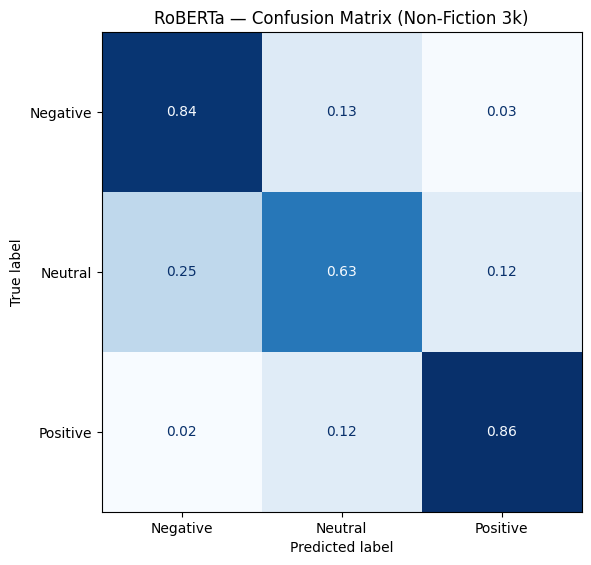

In [41]:
# confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative','Neutral','Positive'])
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
plt.title('RoBERTa — Confusion Matrix (Non-Fiction 3k)')
plt.tight_layout()
plt.savefig('roberta_confmat_nonfiction3k.png', dpi=300)
plt.show()

In [ ]:
# Goodreads db file
REVIEWS_DB = "/kaggle/input/books-dataset-goodreadsmay-2024/book_reviews.db"

In [43]:
import sqlite3
# Connect and inspect tables
con = sqlite3.connect(REVIEWS_DB)
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", con)
print(tables)

           name
0  book_reviews


In [44]:
# See columns in the table
pd.read_sql_query("PRAGMA table_info(book_reviews);", con)


,cid,name,type,notnull,dflt_value,pk
0,0,book_id,TEXT,0,None,0
1,1,reviewer_id,TEXT,0,None,0
2,2,reviewer_name,TEXT,0,None,0
3,3,likes_on_review,TEXT,0,None,0
4,4,review_content,TEXT,0,None,0
5,5,reviewer_followers,TEXT,0,None,0
6,6,reviewer_total_reviews,TEXT,0,None,0
7,7,review_date,TEXT,0,None,0
8,8,review_rating,TEXT,0,None,0


In [45]:
sql = """
SELECT review_content, review_rating
FROM book_reviews
WHERE review_content IS NOT NULL AND TRIM(review_content) <> ''
  AND review_rating IS NOT NULL
"""
df = pd.read_sql_query(sql, con)

In [46]:
# Extract the first digit from strings like "Rating 4 out of 5"
df['stars'] = df['review_rating'].str.extract(r'(\d)').astype(int)

In [47]:
# Map to sentiment labels
def map_rating(s):
    if s in [1, 2]: return 0   # Negative
    if s == 3:      return 1   # Neutral
    if s in [4, 5]: return 2   # Positive
df['label'] = df['stars'].apply(map_rating)

In [48]:
# Make a balanced 3k sample
neg = df[df['label']==0].sample(n=1000, random_state=42)
neu = df[df['label']==1].sample(n=1000, random_state=42)
pos = df[df['label']==2].sample(n=1000, random_state=42)

In [49]:
goodreads_balanced = pd.concat([neg, neu, pos]).sample(frac=1, random_state=42).reset_index(drop=True)
goodreads_balanced = goodreads_balanced.rename(columns={'review_content':'cleaned_text'})
print(goodreads_balanced.shape)

(3000, 4)


In [50]:
goodreads_balanced.head()

,cleaned_text,review_rating,stars,label
0,"Older NR. She always has great characters, but...",Rating 3 out of 5,3,1
1,Beats the pants off Harry Potter. Wonderful YA...,Rating 3 out of 5,3,1
2,If not for the fact that this is a satire in e...,Rating 3 out of 5,3,1
3,While I liked the premise behind this ( nursin...,Rating 2 out of 5,2,0
4,A strange and delightful little story. It has ...,Rating 5 out of 5,5,2


In [51]:
review_lengths = goodreads_balanced['cleaned_text'].apply(lambda x: len(str(x).split()))
print(review_lengths.describe())

count    3000.000000
mean      375.125667
std       390.700987
min         2.000000
25%       120.750000
50%       257.500000
75%       495.000000
max      3237.000000
Name: cleaned_text, dtype: float64


In [52]:
from datasets import Dataset

goodreads_ds = Dataset.from_pandas(
    goodreads_balanced[['cleaned_text', 'label']].rename(columns={'cleaned_text':'text'}),
    preserve_index=False
)

In [53]:
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=256)

goodreads_tok = goodreads_ds.map(tokenize, batched=True, remove_columns=['text'])


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [54]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

preds = trainer.predict(goodreads_tok)
y_true = np.array(goodreads_tok['label'])
y_pred = np.argmax(preds.predictions, axis=1)

# Report
print(classification_report(
    y_true, y_pred, target_names=['Negative','Neutral','Positive'], digits=2, zero_division=0
))

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


              precision    recall  f1-score   support

    Negative       0.78      0.73      0.75      1000
     Neutral       0.60      0.61      0.60      1000
    Positive       0.72      0.76      0.74      1000

    accuracy                           0.70      3000
   macro avg       0.70      0.70      0.70      3000
weighted avg       0.70      0.70      0.70      3000



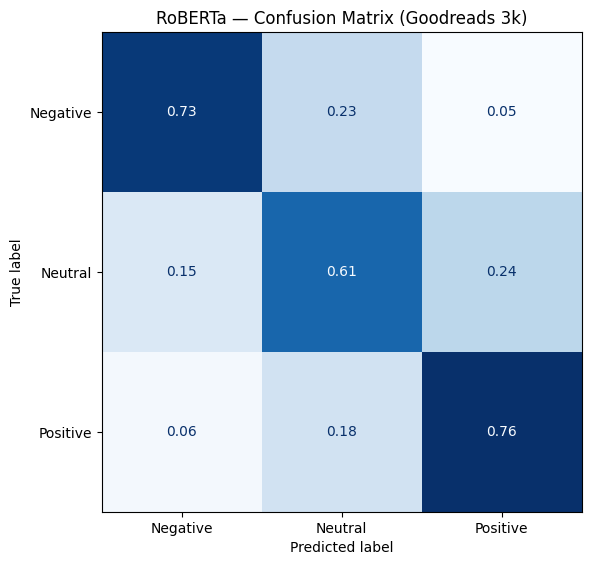

In [55]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative','Neutral','Positive'])
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
plt.title('RoBERTa — Confusion Matrix (Goodreads 3k)')
plt.tight_layout()
plt.savefig('roberta_confmat_goodreads3k.png', dpi=300)
plt.show()
